#  추천 시스템 - Text2SQL 기반 RAG 시스템

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Langsmith tracing 여부를 확인 (true: langsmith 추척 활성화, false: langsmith 추척 비활성화)
import os
print(os.getenv('LANGSMITH_TRACING'))

false


`(3) SQLite DB`

In [4]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///etf_database.db")
print(db.dialect)
print(db.get_usable_table_names())
etfs = db.run("SELECT * FROM ETFs LIMIT 5;")

for etf in eval(etfs):
    print(etf)

sqlite
['ETFs', 'ETFsInfo']
('466400', '1Q 25-08 회사채(A+이상)액티브', '2023/09/19', '채권-회사채-단기', '하나자산운용', 4.52, 'KIS 2025-08만기형 크레딧 A+이상 지수(총수익)', 0.11, 111916276404.0, 0.03, '매우낮음', '실물(액티브)', 0.1, '배당소득세(보유기간과세)')
('491610', '1Q CD금리액티브(합성)', '2024/09/24', '기타', '하나자산운용', 0.0, 'KIS 하나 CD금리 총수익지수', 0.05, 316206006696.0, 0.02, '매우낮음', '합성(액티브)', 0.02, '배당소득세(보유기간과세)')
('451060', '1Q K200액티브', '2023/01/31', '주식-시장대표', '하나자산운용', -3.66, '코스피 200', 0.77, 99754348820.0, -0.01, '높음', '실물(액티브)', 0.18, '배당소득세(보유기간과세)')
('463290', '1Q 단기금융채액티브', '2023/08/03', '채권-혼합-단기', '하나자산운용', 4.01, 'MK 머니마켓 지수(총수익)', 0.05, 252717462257.0, 0.0, '매우낮음', '실물(액티브)', 0.08, '배당소득세(보유기간과세)')
('479080', '1Q 머니마켓액티브', '2024/04/02', '채권-혼합-단기', '하나자산운용', 0.0, 'KIS-하나 MMF 지수(총수익)', 0.06, 308255065986.0, -0.01, '매우낮음', '실물(액티브)', 0.05, '배당소득세(보유기간과세)')


---

## **SQL QA** 

- **SQL 기반 Q&A 시스템**은 구조화된 데이터를 LLM으로 처리하는 특수 사례
    - **자연어 처리**를 통한 SQL 쿼리 자동 변환 구현
    - 데이터베이스에서 **쿼리 실행 및 결과 추출** 
    - 추출된 데이터를 활용한 **자연어 답변 생성**

- **Chain**과 **Agent** 두 가지 구현 방식으로 자연어 질문에 대한 답변 제공

- **LangGraph**를 활용한 반복적 데이터베이스 쿼리 실행 가능

- **참조**: https://python.langchain.com/docs/tutorials/sql_qa/

### 1) **Chain** 방식

- **단순 실행 흐름**으로 예측 가능한 결과 도출

- **단일 쿼리** 실행만으로 해결 가능한 단순 질의에 최적화

- 명확한 **입력-출력 구조**로 안정적 동작 보장

`(1) State 상태 정의`

- **LangGraph 상태 관리**를 위한 TypedDict 구조 정의

- 입력 **질문**, **쿼리**, **결과**, **답변**의 4가지 핵심 상태 추적

- 상태 데이터의 단계별 전달로 실행 흐름 제어

In [5]:
from typing import TypedDict

# 상태 정보를 저장하는 State 클래스
class State(TypedDict):
    question: str  # 입력 질문
    query: str     # 생성된 쿼리
    result: str    # 쿼리 결과
    answer: str    # 생성된 답변

`(2) 프롬프트 템플릿`

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from typing_extensions import TypedDict, Annotated

# 프롬프트 템플릿 생성
query_prompt_template = ChatPromptTemplate.from_messages([
    ("system", """
    Given an input question, create a syntactically correct {dialect} query to run to help find the answer. 
    Unless the user specifies in his question a specific number of examples they wish to obtain, 
    always limit your query to at most {top_k} results.
      
    You can order the results by a relevant column to return the most interesting examples in the database.
    Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.
    Pay attention to use only the column names that you can see in the schema description. 
    Be careful to not query for columns that do not exist.
      
    Also, pay attention to which column is in which table.
    Only use the following tables:
    {table_info}
    """),
    ("user", """
    Question:
    {input}
    """)
])

# 프롬프트 템플릿 출력
for m in query_prompt_template.messages:
   m.pretty_print()

================================ System Message ================================


    Given an input question, create a syntactically correct {dialect} query to run to help find the answer. 
    Unless the user specifies in his question a specific number of examples they wish to obtain, 
    always limit your query to at most {top_k} results.

    You can order the results by a relevant column to return the most interesting examples in the database.
    Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.
    Pay attention to use only the column names that you can see in the schema description. 
    Be careful to not query for columns that do not exist.

    Also, pay attention to which column is in which table.
    Only use the following tables:
    {table_info}
    
================================ Human Message =================================


    Question:
    {input}
    


In [7]:
# required 입력 필드 확인 (dialect, input, table_info, top_k)
query_prompt_template.input_schema.model_json_schema()

{'properties': {'dialect': {'title': 'Dialect', 'type': 'string'},
  'input': {'title': 'Input', 'type': 'string'},
  'table_info': {'title': 'Table Info', 'type': 'string'},
  'top_k': {'title': 'Top K', 'type': 'string'}},
 'required': ['dialect', 'input', 'table_info', 'top_k'],
 'title': 'PromptInput',
 'type': 'object'}

`(3) SQL 쿼리 생성`

In [8]:
from langchain_openai import ChatOpenAI

# llm 모델 생성
llm = ChatOpenAI(model="gpt-4o-mini")

In [9]:
from typing import Annotated, TypedDict

class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [10]:
# 쿼리 실행
response = write_query({"question": "총보수가 0.1% 이하인 ETF는 무엇인가요?"}) 

response

{'query': 'SELECT 종목코드, 종목명, 총보수 FROM ETFs WHERE 총보수 <= 0.1 LIMIT 10;'}

`(4) SQL 쿼리 실행`

In [11]:
from langchain_community.tools import QuerySQLDatabaseTool

def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [12]:
execute_query({"query": response["query"]})

{'result': "[('466400', '1Q 25-08 회사채(A+이상)액티브', 0.1), ('491610', '1Q CD금리액티브(합성)', 0.02), ('463290', '1Q 단기금융채액티브', 0.08), ('479080', '1Q 머니마켓액티브', 0.05), ('495330', '1Q 코리아밸류업', 0.02), ('492500', '1Q 현대차그룹채권(A+이상)&국고통안', 0.1), ('473440', 'ACE 11월만기자동연장회사채AA-이상액티브', 0.05), ('105190', 'ACE 200', 0.09), ('332500', 'ACE 200TR', 0.03), ('461260', 'ACE 25-06 회사채(AA-이상)액티브', 0.05)]"}

`(5) RAG 답변 생성`

In [13]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [14]:
question = "총보수가 0.1% 이하인 ETF는 무엇인가요?"

query = write_query({"question": question})["query"]  #type: ignore
result = execute_query({"query": query})["result"]    #type: ignore

response = generate_answer({
    "question": question,
    "query": query,
    "result": result,
})   #type: ignore

print(response["answer"])

총보수가 0.1% 이하인 ETF는 다음과 같습니다:

1. 종목코드: 265690, 종목명: ACE 러시아MSCI(합성), 총보수: 0.0%
2. 종목코드: 495850, 종목명: KODEX 코리아밸류업, 총보수: 0.008%
3. 종목코드: 495050, 종목명: RISE 코리아밸류업, 총보수: 0.008%
4. 종목코드: 496080, 종목명: TIGER 코리아밸류업, 총보수: 0.008%
5. 종목코드: 449180, 종목명: KODEX 미국S&P500(H), 총보수: 0.009%
6. 종목코드: 379800, 종목명: KODEX 미국S&P500TR, 총보수: 0.009%
7. 종목코드: 449190, 종목명: KODEX 미국나스닥100(H), 총보수: 0.009%
8. 종목코드: 379810, 종목명: KODEX 미국나스닥100TR, 총보수: 0.009%
9. 종목코드: 489250, 종목명: KODEX 미국배당다우존스, 총보수: 0.009%
10. 종목코드: 496090, 종목명: KOSEF 코리아밸류업, 총보수: 0.009%

이 ETF들은 모두 총보수가 0.1% 이하입니다.


`(6) LangGraph 통합`

- langgraph 설치 (pip 또는 uv)

In [15]:
from langgraph.graph import START, StateGraph 

graph_builder = StateGraph(State)

graph_builder.add_node("write_query", write_query)
graph_builder.add_node("execute_query", execute_query)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query", "execute_query")
graph_builder.add_edge("execute_query", "generate_answer")  
graph = graph_builder.compile()

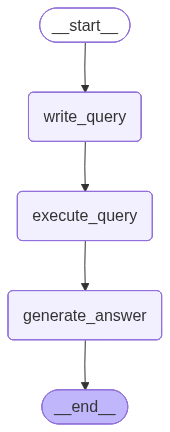

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
for step in graph.stream(
    {"question": "총보수가 0.1% 이하인 ETF는 모두 몇 개인가요?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS 수 FROM ETFs WHERE 총보수 <= 0.1 LIMIT 10;'}}
{'execute_query': {'result': '[(246,)]'}}
{'generate_answer': {'answer': '총보수가 0.1% 이하인 ETF는 총 246개입니다.'}}


### 2) **Agent** 방식

- **반복 쿼리 실행**으로 복잡한 데이터 분석 가능

- 오류 발생 시 **자동 복구 메커니즘** 작동

- **DB 스키마 기반**의 정확한 답변 생성

- 다단계 추론이 필요한 **복잡한 질의** 처리 가능

`(1) 필요한 도구 준비`

- **ReAct 에이전트**와 **SQLDatabaseToolkit** 통합으로 고급 쿼리 처리
- 다중 쿼리 실행, **오류 복구**, 스키마 기반 응답 기능 제공
- 쿼리 생성, 구문 검사, 테이블 정보 조회 등 **다양한 도구** 활용

In [18]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002152BA22330>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002152BA22330>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002152BA22330>),
 QuerySQLCheckerTool(description='Use this tool to 

`(2) 프롬프트 템플릿`

In [19]:
system_message = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, 
then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, 
always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables.
""".format(dialect=db.dialect, top_k=5)

print(system_message)


You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct sqlite query to run, 
then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, 
always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what y

`(3) ReAct 에이전트 초기화`

In [20]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, prompt=system_message)

`(4) ReAct 에이전트 실행`

In [21]:
from langchain_core.messages import HumanMessage

question = "총보수가 0.1% 이하인 ETF는 모두 몇 개인가요?"

for step in agent_executor.stream(
    {"messages": [HumanMessage(content=question)]}, 
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

총보수가 0.1% 이하인 ETF는 모두 몇 개인가요?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_QIP6z22MQe3bW8BaZkt27Mfe)
 Call ID: call_QIP6z22MQe3bW8BaZkt27Mfe
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

ETFs, ETFsInfo
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_7lgS3gTX5eXtJcYe4NPsZ72i)
 Call ID: call_7lgS3gTX5eXtJcYe4NPsZ72i
  Args:
    table_names: ETFs
  sql_db_schema (call_rZuNAFJgTctJCeECy62XuvJP)
 Call ID: call_rZuNAFJgTctJCeECy62XuvJP
  Args:
    table_names: ETFsInfo
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "ETFsInfo" (
	"한글명" TEXT, 
	"영문명" TEXT, 
	"종목코드" TEXT, 
	"상장일" TEXT, 
	"펀드형태" TEXT, 
	"기초지수명" TEXT, 
	"추적배수" TEXT, 
	"자산운용사

## **DB 테이블 관리** 

- **테이블 선택** 및 **다중 테이블 처리** 기능으로 유연한 데이터 관리
- 자연어로 표현된 질문을 **SQL로 자동 변환** 및 실행
- 테이블 관리와 SQL 실행을 통합한 지능형 데이터베이스 시스템 구현

`(1) 특정 테이블만 선택`

- **Sakila Sample Database**
- 출처: https://www.kaggle.com/datasets/atanaskanev/sqlite-sakila-sample-database/data

In [22]:
from langchain_community.utilities import SQLDatabase

# SQLite 데이터베이스 연결
db = SQLDatabase.from_uri("sqlite:///sqlite-sakila.db", sample_rows_in_table_info=3)

# 데이터베이스 정보 확인
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['actor', 'address', 'category', 'city', 'country', 'customer', 'film', 'film_actor', 'film_category', 'film_text', 'inventory', 'language', 'payment', 'rental', 'staff', 'store']


In [23]:
from langchain_community.utilities import SQLDatabase

# 일부 테이블 제외
simple_db = SQLDatabase.from_uri(
    "sqlite:///sqlite-sakila.db",
    ignore_tables=['actor', 'address', 'category', 'city', 'country', 'customer', 'inventory', 'language', 'payment', 'rental', 'staff', 'store'],
    )
print(simple_db.dialect)

# 사용 가능한 테이블 목록
print(simple_db.get_usable_table_names())

sqlite
['film', 'film_actor', 'film_category', 'film_text']


In [24]:
films = db.run("SELECT * FROM film LIMIT 5;")

for etf in eval(films):
    print(etf)

(1, 'ACADEMY DINOSAUR', 'A Epic Drama of a Feminist And a Mad Scientist who must Battle a Teacher in The Canadian Rockies', '2006', 1, None, 6, 0.99, 86, 20.99, 'PG', 'Deleted Scenes,Behind the Scenes', '2021-03-06 15:52:00')
(2, 'ACE GOLDFINGER', 'A Astounding Epistle of a Database Administrator And a Explorer who must Find a Car in Ancient China', '2006', 1, None, 3, 4.99, 48, 12.99, 'G', 'Trailers,Deleted Scenes', '2021-03-06 15:52:00')
(3, 'ADAPTATION HOLES', 'A Astounding Reflection of a Lumberjack And a Car who must Sink a Lumberjack in A Baloon Factory', '2006', 1, None, 7, 2.99, 50, 18.99, 'NC-17', 'Trailers,Deleted Scenes', '2021-03-06 15:52:00')
(4, 'AFFAIR PREJUDICE', 'A Fanciful Documentary of a Frisbee And a Lumberjack who must Chase a Monkey in A Shark Tank', '2006', 1, None, 5, 2.99, 117, 26.99, 'G', 'Commentaries,Behind the Scenes', '2021-03-06 15:52:00')
(5, 'AFRICAN EGG', 'A Fast-Paced Documentary of a Pastry Chef And a Dentist who must Pursue a Forensic Psychologist 

`(2) 복잡한 DB 스키마 처리`

- 테이블들을 Film, Customer, Location 3개의 카테고리로 그룹화
- Pydantic 모델을 사용하여 테이블 구조 정의

In [25]:
# 데이터베이스 정보 확인
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['actor', 'address', 'category', 'city', 'country', 'customer', 'film', 'film_actor', 'film_category', 'film_text', 'inventory', 'language', 'payment', 'rental', 'staff', 'store']


In [26]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from operator import itemgetter
from typing import List

# 테이블 카테고리 정의를 위한 Pydantic 모델
class Table(BaseModel):
    """SQL 데이터베이스의 테이블."""
    name: str = Field(description="SQL 데이터베이스의 테이블 이름")
    category: str = Field(description="테이블이 속하는 카테고리")
    purpose: str = Field(description="테이블의 주요 목적 및 역할")

class TableList(BaseModel):
    """SQL 데이터베이스의 테이블 목록."""
    tables: List[Table] = Field(description="관련된 테이블들의 목록")

# LLM 모델 초기화
llm = ChatOpenAI(model='gpt-4o-mini')

# 실제 SQLite Sakila 테이블에 맞춘 시스템 프롬프트
system = """당신은 Sakila DVD 대여점 데이터베이스의 전문가입니다.
사용자 질문과 관련된 SQL 테이블들을 식별하고 적절한 카테고리로 분류하세요.

## 실제 SQLite Sakila 데이터베이스 테이블 구조:
테이블 목록: ['actor', 'address', 'category', 'city', 'country', 'customer', 'film', 'film_actor', 'film_category', 'film_text', 'inventory', 'language', 'payment', 'rental', 'staff', 'store']

### 🎬 Film (영화 및 콘텐츠)
- **film**: 영화 기본 정보 
- **film_category**: 영화-카테고리 관계 테이블 
- **film_actor**: 영화-배우 관계 테이블 
- **category**: 영화 장르/카테고리 
- **language**: 영화 언어 정보 
- **actor**: 배우 정보 

### 👥 Customer (고객 및 직원)
- **customer**: 고객 정보 
- **staff**: 직원 정보 

### 💰 Transaction (거래 및 대여)
- **rental**: 대여 기록 
- **payment**: 결제 정보 

### 📦 Inventory (재고 관리)
- **inventory**: 영화 재고 정보 

### 🏪 Location (위치 및 매장)
- **store**: 매장 정보 
- **address**: 주소 정보 
- **city**: 도시 정보 
- **country**: 국가 정보

## 테이블 간 주요 관계:
- **customer** → **rental** → **payment**: 고객이 영화를 대여하고 결제
- **film** → **inventory** → **rental**: 영화 재고를 통한 대여 관리
- **film** ↔ **actor** (film_actor): 영화와 배우 다대다 관계
- **film** ↔ **category** (film_category): 영화와 장르 다대다 관계
- **store** → **inventory**: 매장별 재고 관리
- **address** → **city** → **country**: 계층적 주소 구조
- **staff** → **store**: 직원과 근무 매장 관계

## 분석 시 고려사항:
- 대여 분석: rental, customer, inventory, film 테이블 조합 필요
- 매출 분석: payment, rental, customer 테이블 조합 필요  
- 영화 검색: film, film_text, actor, category, language 테이블 활용
- 지역별 분석: store, address, city, country 테이블 조합 필요

사용자 질문을 분석하여 관련된 테이블들을 식별하고, 각 테이블의 카테고리와 목적을 명시하세요."""

# 프롬프트 템플릿 생성
prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "질문: {input}\n\n위 질문에 답하기 위해 필요한 테이블들을 식별하고 분류해주세요."),
])

# LLM 구조화 출력 설정
structure_llm = llm.with_structured_output(TableList)

# 카테고리 체인 생성
category_chain = prompt | structure_llm

In [27]:
# Customer 카테고리 체인 실행 
question = "어떤 고객이 가장 많은 영화를 대여했나요?"
table_list = category_chain.invoke({"input": question})

for table in table_list.tables:
    print(f"📋 테이블: {table.name}")
    print(f"   카테고리: {table.category}")
    print(f"   목적: {table.purpose}")
    print()

📋 테이블: customer
   카테고리: 👥 Customer (고객 및 직원)
   목적: 고객 정보 제공

📋 테이블: rental
   카테고리: 💰 Transaction (거래 및 대여)
   목적: 대여 기록 관리

📋 테이블: inventory
   카테고리: 📦 Inventory (재고 관리)
   목적: 영화 재고 정보 제공

📋 테이블: film
   카테고리: 🎬 Film (영화 및 콘텐츠)
   목적: 영화 기본 정보 제공



In [28]:
# Film 카테고리 체인 실행
question = "가장 인기 있는 영화 장르는 무엇인가요?"
table_list = category_chain.invoke({"input": question})

for table in table_list.tables:
    print(f"📋 테이블: {table.name}")
    print(f"   카테고리: {table.category}")
    print(f"   목적: {table.purpose}")
    print()

📋 테이블: category
   카테고리: 🎬 Film (영화 및 콘텐츠)
   목적: 영화 장르/카테고리 정보 제공

📋 테이블: film_category
   카테고리: 🎬 Film (영화 및 콘텐츠)
   목적: 영화와 장르 간의 관계 테이블로, 영화가 어떤 장르에 속하는지 정보 제공

📋 테이블: film
   카테고리: 🎬 Film (영화 및 콘텐츠)
   목적: 영화의 기본 정보 및 인기도 확인을 위한 데이터 제공

📋 테이블: rental
   카테고리: 💰 Transaction (거래 및 대여)
   목적: 대여 기록을 통해 각 카테고리의 영화 대여 횟수 분석

📋 테이블: payment
   카테고리: 💰 Transaction (거래 및 대여)
   목적: 결제 정보로 대여된 영화의 매출 분석을 위한 데이터 제공



In [29]:
# Location 카테고리 체인 실행
question = "각 매장의 총 매출은 얼마인가요?"
table_list = category_chain.invoke({"input": question})

for table in table_list.tables:
    print(f"📋 테이블: {table.name}")
    print(f"   카테고리: {table.category}")
    print(f"   목적: {table.purpose}")
    print()


📋 테이블: payment
   카테고리: Transaction
   목적: 결제 정보를 담고 있어 매출 분석에 필요

📋 테이블: rental
   카테고리: Transaction
   목적: 대여 기록을 포함하여 매출이 발생하는 상황을 제공

📋 테이블: customer
   카테고리: Customer
   목적: 고객 정보로 매출 관련 분석에 필수적

📋 테이블: store
   카테고리: Location
   목적: 매장 정보를 통해 매출을 매장 단위로 분석할 수 있음



- **모든 테이블 사용**

In [30]:
from typing import Annotated, TypedDict

class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]

# SQL 쿼리 체인 생성
partial_prompt_template = query_prompt_template.format(
    dialect=db.dialect,
    top_k=10,
    table_info="{table_names_to_use}",
    input="{question}"
)

# 프롬프트 템플릿 생성
prompt = ChatPromptTemplate.from_template(partial_prompt_template)

structured_llm = llm.with_structured_output(QueryOutput)
query_chain = prompt | structured_llm

# SQL 쿼리 생성 - 모든 테이블 사용
response = query_chain.invoke({
    "question": "가장 많은 작품을 대여한 고객은 누구인가요?",
    "table_names_to_use": db.get_table_info()})

print(response.get("query"))


SELECT c.first_name, c.last_name, COUNT(r.rental_id) AS rental_count
FROM customer c
JOIN rental r ON c.customer_id = r.customer_id
GROUP BY c.customer_id
ORDER BY rental_count DESC
LIMIT 10;


In [31]:
# SQL 쿼리 실행
db.run(response.get("query"))

"[('ELEANOR', 'HUNT', 46), ('KARL', 'SEAL', 45), ('CLARA', 'SHAW', 42), ('MARCIA', 'DEAN', 42), ('TAMMY', 'SANDERS', 41), ('SUE', 'PETERS', 40), ('WESLEY', 'BULL', 40), ('RHONDA', 'KENNEDY', 39), ('MARION', 'SNYDER', 39), ('TIM', 'CARY', 39)]"

- **일부 테이블 사용**

In [32]:
# 테이블 이름 체인 생성 (테이블 이름 추출)
table_chain = (
    {"input": itemgetter("question")} 
    | category_chain 
    | RunnableLambda(lambda x: [t.name for t in x.tables])
)

# 테이블 이름 체인 실행
table_chain.invoke({"question": "가장 많은 작품을 대여한 고객은 누구인가요?"})

['customer', 'rental', 'film']

In [33]:
# 최종 체인 연결 (테이블 이름 추출 -> SQL 쿼리 생성) -> 추출된 일부 테이블 정보를 사용하여 쿼리 생성
full_chain = RunnablePassthrough.assign(
    table_names_to_use=table_chain | RunnableLambda(lambda x: db.get_table_info(x))
    ) | query_chain

response = full_chain.invoke({"question": "가장 많은 작품을 대여한 고객은 누구인가요?"})
print(response.get("query"))

SELECT c.first_name, c.last_name, COUNT(r.rental_id) AS rentals_count
FROM customer c
JOIN rental r ON c.customer_id = r.customer_id
GROUP BY c.customer_id
ORDER BY rentals_count DESC
LIMIT 10;


In [34]:
# SQL 쿼리 실행
db.run(response.get("query")) 

"[('ELEANOR', 'HUNT', 46), ('KARL', 'SEAL', 45), ('CLARA', 'SHAW', 42), ('MARCIA', 'DEAN', 42), ('TAMMY', 'SANDERS', 41), ('SUE', 'PETERS', 40), ('WESLEY', 'BULL', 40), ('RHONDA', 'KENNEDY', 39), ('MARION', 'SNYDER', 39), ('TIM', 'CARY', 39)]"

- **Agent로 구현**

In [35]:
from langchain_core.tools import tool
from typing import List
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage

### 1. 테이블 선택 도구 생성

@tool  
def select_relevant_tables(question: str) -> str:
    """질문과 관련된 테이블의 스키마 정보를 반환한다."""
    # 기존 table_chain 결과를 직접 사용
    try:
        selected_tables = table_chain.invoke({"question": question})
        table_info = db.get_table_info(selected_tables)
        return f"관련 테이블: {', '.join(selected_tables)}\n\n{table_info}"
    except Exception as e:
        return f"테이블 선택 중 오류 발생: {str(e)}"


### 2. Agent 구현

# 기본 SQL 도구킷 생성
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
sql_tools = toolkit.get_tools()

# 커스텀 테이블 선택 도구 추가
custom_tools = [select_relevant_tables]  

# 모든 도구 결합
all_tools = sql_tools + custom_tools

# 4. 시스템 메시지 정의 (테이블 선택 기능 포함)
system_message = f"""
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {db.dialect} query to run, 
then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, 
always limit your query to at most 5 results.

You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.

IMPORTANT WORKFLOW:
1. FIRST, use the 'select_relevant_tables' tool to identify relevant tables for the question
2. THEN, if needed, use 'sql_db_list_tables' to see all available tables
3. THEN, use 'sql_db_schema' to get detailed schema for specific tables
4. THEN, use 'sql_db_query_checker' to validate your query before execution
5. FINALLY, use 'sql_db_query' to execute the validated query

You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

Never query for all the columns from a specific table, only ask for the relevant columns given the question.
"""

# Agent 생성
agent_executor = create_react_agent(llm, all_tools, prompt=system_message)

# 실행
question = "가장 많은 작품을 대여한 고객은 누구인가요?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()


================================ Human Message =================================

가장 많은 작품을 대여한 고객은 누구인가요?
================================== Ai Message ==================================
Tool Calls:
  select_relevant_tables (call_cDJrVHocey0PbDF38xXUYehb)
 Call ID: call_cDJrVHocey0PbDF38xXUYehb
  Args:
    question: 가장 많은 작품을 대여한 고객은 누구인가요?
================================= Tool Message =================================
Name: select_relevant_tables

관련 테이블: customer, rental, film


CREATE TABLE customer (
	customer_id INTEGER NOT NULL, 
	store_id INTEGER NOT NULL, 
	first_name VARCHAR(45) NOT NULL, 
	last_name VARCHAR(45) NOT NULL, 
	email VARCHAR(50) DEFAULT NULL, 
	address_id INTEGER NOT NULL, 
	active CHAR(1) DEFAULT 'Y' NOT NULL, 
	create_date TIMESTAMP NOT NULL, 
	last_update TIMESTAMP NOT NULL, 
	PRIMARY KEY (customer_id), 
	CONSTRAINT fk_customer_store FOREIGN KEY(store_id) REFERENCES store (store_id) ON UPDATE CASCADE, 
	CONSTRAINT fk_customer_address FOREIGN KEY(address_id) R

In [36]:
# Film 카테고리 체인 실행
question = "가장 인기 있는 영화 장르는 무엇인가요?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

가장 인기 있는 영화 장르는 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  select_relevant_tables (call_MvWIs6pc5MshhR6NRg6vw5O2)
 Call ID: call_MvWIs6pc5MshhR6NRg6vw5O2
  Args:
    question: 가장 인기 있는 영화 장르는 무엇인가요?
================================= Tool Message =================================
Name: select_relevant_tables

관련 테이블: film_category, category, rental, film


CREATE TABLE category (
	category_id SMALLINT NOT NULL, 
	name VARCHAR(25) NOT NULL, 
	last_update TIMESTAMP NOT NULL, 
	PRIMARY KEY (category_id)
)

/*
3 rows from category table:
category_id	name	last_update
1	Action	2021-03-06 15:52:00
2	Animation	2021-03-06 15:52:00
3	Children	2021-03-06 15:52:00
*/


CREATE TABLE film (
	film_id INTEGER NOT NULL, 
	title VARCHAR(255) NOT NULL, 
	description TEXT DEFAULT NULL, 
	release_year VARCHAR(4) DEFAULT NULL, 
	language_id SMALLINT NOT NULL, 
	original

In [37]:
# Location 카테고리 체인 실행
question = "각 매장의 총 매출은 얼마인가요?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

각 매장의 총 매출은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  select_relevant_tables (call_nrCfCJJ05wRRiDjcAOpaHrrv)
 Call ID: call_nrCfCJJ05wRRiDjcAOpaHrrv
  Args:
    question: 각 매장의 총 매출은 얼마인가요?
================================= Tool Message =================================
Name: select_relevant_tables

관련 테이블: payment, rental, store, customer


CREATE TABLE customer (
	customer_id INTEGER NOT NULL, 
	store_id INTEGER NOT NULL, 
	first_name VARCHAR(45) NOT NULL, 
	last_name VARCHAR(45) NOT NULL, 
	email VARCHAR(50) DEFAULT NULL, 
	address_id INTEGER NOT NULL, 
	active CHAR(1) DEFAULT 'Y' NOT NULL, 
	create_date TIMESTAMP NOT NULL, 
	last_update TIMESTAMP NOT NULL, 
	PRIMARY KEY (customer_id), 
	CONSTRAINT fk_customer_store FOREIGN KEY(store_id) REFERENCES store (store_id) ON UPDATE CASCADE, 
	CONSTRAINT fk_customer_address FOREIGN KEY(address_id) REF

---

## [실습] **Text2SQL RAG 구현**

- "ETFs" 테이블만 선택하여 RAG 시스템을 구현
- Chain 방식과 Agent 방식을 각각 구현하고 테스트
- LangSmith Trace를 분석하여 작동 방식 이해 

In [38]:
# =============================================================================
# [실습] Text2SQL RAG 구현 - ETFs 테이블만 선택
# =============================================================================

print("=" * 80)
print("실습: ETFs 테이블 Text2SQL RAG 구현")
print("=" * 80)

# -----------------------------------------------------------------------------
# 1. ETFs 테이블만 선택하여 데이터베이스 연결
# -----------------------------------------------------------------------------
from langchain_community.utilities import SQLDatabase

# ETFs 테이블만 사용하도록 데이터베이스 연결
etf_db = SQLDatabase.from_uri(
    "sqlite:///etf_database.db",
    include_tables=['ETFs'],  # ETFs 테이블만 포함
    sample_rows_in_table_info=3
)

print(f"\n1. 데이터베이스 설정")
print(f"   - Dialect: {etf_db.dialect}")
print(f"   - 사용 가능한 테이블: {etf_db.get_usable_table_names()}")
print(f"   - 샘플 데이터 확인:")

# 샘플 데이터 확인
sample_data = etf_db.run("SELECT * FROM ETFs LIMIT 3;")
for row in eval(sample_data):
    print(f"     {row}")

# -----------------------------------------------------------------------------
# 2. Chain 방식 구현
# -----------------------------------------------------------------------------
from typing import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.tools import QuerySQLDatabaseTool
from langgraph.graph import START, StateGraph
from typing import Annotated

print("\n" + "=" * 80)
print("2. Chain 방식 구현")
print("=" * 80)

# State 정의
class ETFState(TypedDict):
    question: str
    query: str
    result: str
    answer: str

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 프롬프트 템플릿
query_prompt_template = ChatPromptTemplate.from_messages([
    ("system", """
    Given an input question, create a syntactically correct {dialect} query to run to help find the answer. 
    Unless the user specifies in his question a specific number of examples they wish to obtain, 
    always limit your query to at most {top_k} results.
      
    You can order the results by a relevant column to return the most interesting examples in the database.
    Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.
    Pay attention to use only the column names that you can see in the schema description. 
    Be careful to not query for columns that do not exist.
      
    Also, pay attention to which column is in which table.
    Only use the following tables:
    {table_info}
    """),
    ("user", """
    Question:
    {input}
    """)
])

# QueryOutput 정의
class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]

# SQL 쿼리 생성 함수
def write_etf_query(state: ETFState):
    """Generate SQL query to fetch ETF information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": etf_db.dialect,
            "top_k": 10,
            "table_info": etf_db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

# SQL 쿼리 실행 함수
def execute_etf_query(state: ETFState):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=etf_db)
    return {"result": execute_query_tool.invoke(state["query"])}

# 답변 생성 함수
def generate_etf_answer(state: ETFState):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question in Korean.\\n\\n"
        f'Question: {state["question"]}\\n'
        f'SQL Query: {state["query"]}\\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

# LangGraph 구축
graph_builder = StateGraph(ETFState)

graph_builder.add_node("write_query", write_etf_query)
graph_builder.add_node("execute_query", execute_etf_query)
graph_builder.add_node("generate_answer", generate_etf_answer)

graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query", "execute_query")
graph_builder.add_edge("execute_query", "generate_answer")

etf_chain_graph = graph_builder.compile()

print("\n✅ Chain 방식 그래프 생성 완료")

# Chain 방식 테스트
test_questions_chain = [
    "총보수가 0.1% 이하인 ETF는 모두 몇 개인가요?",
    "순자산총액이 가장 큰 ETF는 무엇인가요?",
    "배당지급 주기가 매월인 ETF를 3개만 알려주세요."
]

print("\n[Chain 방식 테스트]")
for i, question in enumerate(test_questions_chain, 1):
    print(f"\n--- 질문 {i}: {question}")
    result = None
    for step in etf_chain_graph.stream(
        {"question": question}, 
        stream_mode="updates"
    ):
        if "generate_answer" in step:
            result = step["generate_answer"]["answer"]
    if result:
        print(f"답변: {result}")

# -----------------------------------------------------------------------------
# 3. Agent 방식 구현
# -----------------------------------------------------------------------------
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage

print("\n" + "=" * 80)
print("3. Agent 방식 구현")
print("=" * 80)

# SQLDatabaseToolkit 생성
etf_toolkit = SQLDatabaseToolkit(db=etf_db, llm=llm)
etf_tools = etf_toolkit.get_tools()

print(f"\n사용 가능한 도구: {[tool.name for tool in etf_tools]}")

# Agent 시스템 메시지
etf_system_message = f"""
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {etf_db.dialect} query to run, 
then look at the results of the query and return the answer in Korean.
Unless the user specifies a specific number of examples they wish to obtain, 
always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables.

Answer all questions in Korean (한국어로 답변하세요).
"""

# ReAct Agent 생성
etf_agent_executor = create_react_agent(llm, etf_tools, prompt=etf_system_message)

print("\n✅ Agent 방식 구현 완료")

# Agent 방식 테스트
test_questions_agent = [
    "총보수가 0.15% 이하인 ETF는 몇 개인가요?",
    "순자산총액이 1조원 이상인 ETF의 평균 총보수는 얼마인가요?"
]

print("\n[Agent 방식 테스트]")
for i, question in enumerate(test_questions_agent, 1):
    print(f"\n--- 질문 {i}: {question}")
    print("-" * 60)
    
    messages_list = []
    for step in etf_agent_executor.stream(
        {"messages": [HumanMessage(content=question)]}, 
        stream_mode="values",
    ):
        # 마지막 메시지만 수집
        messages_list = step["messages"]
    
    # 최종 답변만 출력
    if messages_list:
        final_answer = messages_list[-1]
        if hasattr(final_answer, 'content'):
            print(f"\n최종 답변: {final_answer.content}")

# -----------------------------------------------------------------------------
# 4. 결과 요약
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("4. 실습 완료 요약")
print("=" * 80)
print("""
✅ 구현 완료 항목:
   1. ETFs 테이블만 선택하여 데이터베이스 연결
   2. Chain 방식 - LangGraph를 사용한 순차적 쿼리 실행
   3. Agent 방식 - ReAct 에이전트를 사용한 자율적 쿼리 실행
   4. 다양한 테스트 질문으로 검증

📊 Chain vs Agent 비교:
   - Chain: 단순하고 예측 가능한 흐름, 단일 쿼리에 최적화
   - Agent: 복잡한 질문 처리 가능, 오류 복구 메커니즘, 다단계 추론

🔍 LangSmith Trace 분석 포인트:
   - Chain: write_query → execute_query → generate_answer 순차 실행
   - Agent: 도구 선택 → 쿼리 생성 → 실행 → 결과 분석 → 답변 생성 (반복 가능)
""")

실습: ETFs 테이블 Text2SQL RAG 구현

1. 데이터베이스 설정
   - Dialect: sqlite
   - 사용 가능한 테이블: ['ETFs']
   - 샘플 데이터 확인:
     ('466400', '1Q 25-08 회사채(A+이상)액티브', '2023/09/19', '채권-회사채-단기', '하나자산운용', 4.52, 'KIS 2025-08만기형 크레딧 A+이상 지수(총수익)', 0.11, 111916276404.0, 0.03, '매우낮음', '실물(액티브)', 0.1, '배당소득세(보유기간과세)')
     ('491610', '1Q CD금리액티브(합성)', '2024/09/24', '기타', '하나자산운용', 0.0, 'KIS 하나 CD금리 총수익지수', 0.05, 316206006696.0, 0.02, '매우낮음', '합성(액티브)', 0.02, '배당소득세(보유기간과세)')
     ('451060', '1Q K200액티브', '2023/01/31', '주식-시장대표', '하나자산운용', -3.66, '코스피 200', 0.77, 99754348820.0, -0.01, '높음', '실물(액티브)', 0.18, '배당소득세(보유기간과세)')

2. Chain 방식 구현

✅ Chain 방식 그래프 생성 완료

[Chain 방식 테스트]

--- 질문 1: 총보수가 0.1% 이하인 ETF는 모두 몇 개인가요?
답변: 총보수가 0.1% 이하인 ETF는 246개입니다.

--- 질문 2: 순자산총액이 가장 큰 ETF는 무엇인가요?
답변: 순자산총액이 가장 큰 ETF는 'KODEX CD금리액티브(합성)'이며, 순자산총액은 9,591,343,573,385 원입니다.

--- 질문 3: 배당지급 주기가 매월인 ETF를 3개만 알려주세요.
답변: 죄송하지만 SQL 결과가 제공되지 않아 특정 ETF를 알려드릴 수 없습니다. 하지만 매월 배당 지급 주기를 가진 ETF를 찾기 위해서는 ETF 목록에서 과세유형이 '매월'인 ETF를 확인하시면 됩니다. 추